In [8]:
# -----------------------------OpenSG------------------------------
# -------------------Euler Bernoulli Beam Model--------------------
#
# This code is developed by Multiscale Structural Mechanics laboratory 
# at Purdue University under the supervision of Prof. Wenbin Yu. This 
# code is intended for general purpose usage for performing accurate
# and precise structural analysis. The code is based on Mechanics of 
# Structure Genome (MSG) theory to perform homogenization and 
# dehomogenization of complex composite laminates like wind blades.
#
# -----------------------------mesh import-------------------------------
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.interpolate import griddata
%matplotlib inline
plt.style.use('classic')
import time
import scipy

# ** User Input- .msh file name**
fname= "SG40_2D"
import subprocess
subprocess.check_output('dolfin-convert  '+ fname+ '.msh  '+ fname +'.xml', shell=True)
mesh = Mesh(fname + ".xml")
subdomains = MeshFunction("size_t", mesh, fname + "_physical_region.xml")
#facets = MeshFunction("size_t", mesh, fname + "_facet_region.xml")

# -------------------------------Periodic Boundary Conditions-------------------------------
vertices = np.array([[0.1,0,0],   # 1: Right (x+)
                     [0,0,0]])   # 4: left   (x-)   

# ** Taking any geometric periodic points on x+ and x- face respectively based on beam model (3D SG)**

class PeriodicBoundary(SubDomain):
    def __init__(self, vertices, tolerance=DOLFIN_EPS):
        SubDomain.__init__(self, tolerance)
        self.tol = tolerance
        self.vv = vertices
        self.a1 = self.vv[0,:]-self.vv[1,:] # first vector generating periodicity
        
    def inside(self, x, on_boundary):
        # faces
        left = near(x[0],self.vv[1,0]) 
        return bool((left) and on_boundary)

    def map(self, x, y):
        """ Mapping the right boundary to left """  
        # faces
        right = near(x[0],self.vv[0,0])
        if right:
            y[0] = x[0] - (self.a1[0])
            y[1] = x[1] - (self.a1[1])
            y[2] = x[2] - (self.a1[2])
        else: 
            y[0] = x[0] 
            y[1] = x[1] 
            y[2] = x[2]  
#-------------------Periodic Boundary Conditions End---------------

#----------------------------- Material Data Input-----------------------------

# **The sequence of material initialization is corresponding to subdomain (physical_region) sequence**

# GELCOAT-1
E1,E2,E3=3.4400E+09, 3.4400E+09, 3.4400E+09
G12,G13,G23= 1.3230E+09, 1.3230E+09, 1.3230E+09
v12,v13,v23 = 0.3,0.3,0.3
material_parameters=[(E1,E2,E3,G12,G13,G23,v12,v13,v23)]

# Gtriax-2
E1,E2,E3= 2.8700E+10, 1.6600E+10, 1.6700E+10
G12,G13,G23= 8.4000E+09, 3.4900E+09, 3.4900E+09
v12,v13,v23 = 0.50, 0.17, 0.0
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# GUNI- 3
E1,E2,E3= 4.4600E+10, 1.7000E+10, 1.6700E+10
G12,G13,G23= 3.2700E+09, 3.5000E+09, 3.4800E+09
v12,v13,v23 = 0.26,0.26,0.35
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# FOAM- 4
E1,E2,E3= 1.2920E+08, 1.2920E+08, 1.2920E+08
G12,G13,G23= 4.8947E+07, 4.8947E+07, 4.8947E+07
v12,v13,v23 = 0.32,0.32,0.32
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

# CarbonUD 5
E1,E2,E3= 1.1450E+11, 8.3900E+09, 8.3900E+09
G12,G13,G23= 5.9900E+09,5.9900E+09, 5.9900E+09
v12,v13,v23 = 0.27,0.27,0.27
material_parameters.append((E1,E2,E3,G12,G13,G23,v12,v13,v23))

nphases = len(material_parameters)

## -----------------------------Functions-----------------------------
#
dim=len(mesh.coordinates()[0])
if dim==2:
    a,b=0,1
elif dim==3:
    a,b=1,2
x = SpatialCoordinate(mesh)
Eps2T=as_tensor([(1,0,0,0,0,0),
                (0,0,0,0,x[a],-x[b]),
                (x[b],0,0,0,0,0),
                (-x[a],0,0,0,0,0)]) 

Eps2=as_tensor([(1,0,x[b],-x[a]),
                (0,0,0,0),
                (0,0,0,0),
                (0,0,0,0),
               (0,x[a],0,0),
               (0,-x[b],0,0)])

def eps(v):
    if dim==2:
        E1=as_vector([0,v[1].dx(0),v[2].dx(1),v[1].dx(1)+v[2].dx(0),v[0].dx(1),v[0].dx(0)])
    elif dim==3:
        E1= as_vector([v[0].dx(0),v[1].dx(1),v[2].dx(2),(v[1].dx(2)+v[2].dx(1)),(v[0].dx(2)+v[2].dx(0)),(v[0].dx(1)+v[1].dx(0))]) 
    return as_tensor([(E1[0],0.5*E1[5],0.5*E1[4]),(0.5*E1[5],E1[1],0.5*E1[3]),(0.5*E1[4],0.5*E1[3],E1[2])]),E1    

def sigma(v, i,Eps):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,eps(v)[1]+Eps)
    return as_tensor([(s1[0],s1[5],s1[4]),(s1[5],s1[1],s1[3]),(s1[4],s1[3],s1[2])]),C,s1

# -----------------------------FE Function Space-----------------------------

Ve = VectorElement("CG", mesh.ufl_cell(), 1,dim=3) 
Re = VectorElement("R", mesh.ufl_cell(), 0,dim=4)
if dim==2:
    W = FunctionSpace(mesh, MixedElement([Ve, Re]))
elif dim==3:
    W = FunctionSpace(mesh, MixedElement([Ve, Re]), constrained_domain=PeriodicBoundary(vertices, tolerance=1e-10))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
Eps= as_vector((1,0,0,0,0,0))
dx = Measure('dx')(domain=mesh, subdomain_data=subdomains)

c1=lamb_[0]*dv[0]+lamb_[1]*dv[1]+lamb_[2]*dv[2]
c2=dlamb[0]*v_[0]+dlamb[1]*v_[1]+dlamb[2]*v_[2]
if dim==2:
    c3=lamb_[3]*(dv[1].dx(1)-dv[2].dx(0))+dlamb[3]*(v_[1].dx(1)-v_[2].dx(0))
elif dim==3:
    c3=lamb_[3]*(dv[2].dx(1)-dv[1].dx(2))+dlamb[3]*(v_[2].dx(1)-v_[1].dx(2))

F2 = sum([inner(sigma(dv, i, Eps)[0], eps(v_)[0])*dx(i) for i in range(nphases)])    
a2=lhs(F2)+(c1+c2+c3)*dx
xx=len(assemble(rhs(F2)).get_local())
# Omega
omega=assemble(sum([Constant(1)*dx(i)for i in range(nphases)]))

# -----------------------------Assembled matrices-----------------------------
# --------------Getting Dhe, V0 

V0 = np.zeros((xx,4))
Dhe=np.zeros((xx,4))
D_ee=np.zeros((4,4))

for p in range(4):   
        Eps=Eps2[:,p] 
        F2 = sum([inner(sigma(dv, i, Eps)[0], eps(v_)[0])*dx(i) for i in range(nphases)])               
        w2 = Function(W) 
        L2=rhs(F2)
        solve(a2 == L2, w2,[])       
        Dhe[:,p]= assemble(L2).get_local() # Dhe matrix formation
        V0[:,p]= (w2.vector().get_local()) # V0 matrix formation

for s in range(4):
    for k in range(4): 
        D_ee[s,k]=assemble(sum([dot(Eps2T,dot(sigma(dv,i,Eps)[1],Eps2))[s,k]*dx(i) for i in range(nphases)]))
        
D1=np.matmul(V0.T,-Dhe)
D_eff= D_ee + D1 
D_eff=D_eff/omega
print(D_eff)
#print('Euler Bernoulli Stiffness Matrix')
#print(Deff_srt)
Comp_srt=np.linalg.inv(D_eff)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
[[ 7.73107218e+10  0.00000000e+00 -1.87499160e+09 -1.36923793e+11]
 [ 0.00000000e+00  2.51469665e+08  0.00000000e+00  0.00000000e+00]
 [-1.87499160e+09  0.00000000e+00  4.89880730e+09  3.55861359e+09]
 [-1.36923793e+11  0.00000000e+00  3.55861359e+09  2.53327420e+11]]


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
1


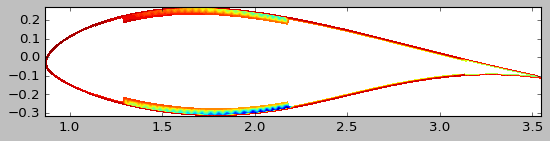

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
2


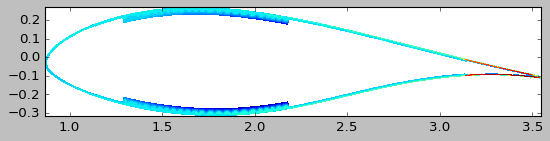

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
3


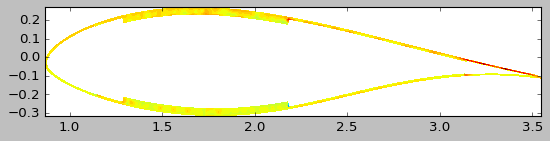

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
4


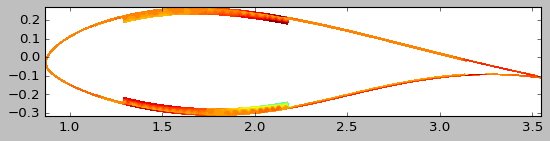

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
5


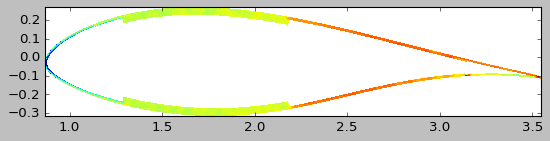

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
6


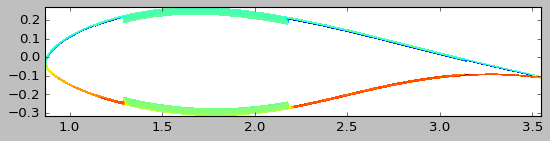

In [10]:
## -----------------------------Dehomogenization-----------------------------
## DEHOMOGENIZATION

# Input Global Strain
st=np.array(([0.01,0.01,0.01,0.01]))

a1=np.matmul(V0,st)
w_1=Function(W)
for i in range(xx):
    w_1.vector()[i]=a1[i]
    
# 3D strain recovery
st_Eb=eps(w_1)[1]+dot(Eps2,as_vector(st))

def sigma_vec(st_3D,i):
    E1,E2,E3,G12,G13,G23,v12,v13,v23= material_parameters[i]
    S=np.zeros((6,6))
    S[0,0], S[1,1], S[2,2]=1/E1, 1/E2, 1/E3
    S[0,1], S[0,2]= -v12/E1, -v13/E1
    S[1,0], S[1,2]= -v12/E1, -v23/E2
    S[2,0], S[2,1]= -v13/E1, -v23/E2
    S[3,3], S[4,4], S[5,5]= 1/G23, 1/G13, 1/G12    
    C=as_tensor(np.linalg.inv(S))
    s1= dot(C,st_3D)
    return s1
V = FunctionSpace(mesh, 'DG', 1)

for pp in range(6):    

    # Create functions in parts
    V0 = FunctionSpace(mesh, 'DG', 1)
    u0 = project(sigma_vec(st_Eb,0)[pp], V0)

    V1 = FunctionSpace(mesh, 'DG', 1)
    u1 = project(sigma_vec(st_Eb,1)[pp], V1)

    V2 = FunctionSpace(mesh, 'DG', 1)
    u2 = project(sigma_vec(st_Eb,2)[pp], V2)

    V3 = FunctionSpace(mesh, 'DG', 1)
    u3 = project(sigma_vec(st_Eb,3)[pp], V3)

    V4 = FunctionSpace(mesh, 'DG', 1)
    u4 = project(sigma_vec(st_Eb,4)[pp], V4)

    # Begin glueing
    uu = TrialFunction(V)
    vv = TestFunction(V)
    aa = inner(uu, vv)*dx

    # Function v0 is u0 in mesh0 and 0 otherwise
    L0 = inner(u0, vv)*dx(0, subdomain_data=subdomains)
    v0 = Function(V)
    solve(aa == L0, v0)

    # Function v1 is u1 in mesh1 and 0 otherwise
    L1 = inner(u1, vv)*dx(1, subdomain_data=subdomains)
    v1 = Function(V)
    solve(aa == L1, v1)

    # Function v2 is u2 in mesh2 and 0 otherwise
    L2 = inner(u2, vv)*dx(2, subdomain_data=subdomains)
    v2 = Function(V)
    solve(aa == L2, v2)

    # Function v3 is u3 in mesh3 and 0 otherwise
    L3 = inner(u3, vv)*dx(3, subdomain_data=subdomains)
    v3 = Function(V)
    solve(aa == L3, v3)

    # Function v4 is u4 in mesh4 and 0 otherwise
    L4 = inner(u4, vv)*dx(4, subdomain_data=subdomains)
    v4 = Function(V)
    solve(aa == L4, v4)

    # Combine
    vvv = Function(V, v0.vector())
    vvv.vector()[:] += v1.vector()
    vvv.vector()[:] += v2.vector()
    vvv.vector()[:] += v3.vector()
    vvv.vector()[:] += v4.vector()
    plot(vvv)
    print(pp+1)
    plt.show()